# Model Performance Comparison

## Version Comparison

| Metric | V1 (Base) | V2 (Class Weights) | V3 (Progressive Unfreezing) |
|--------|-----------|-------------------|----------------------------|
| Test Accuracy | 85.79% | 63.64% | 87.83% |
| F1-Macro | 0.7989 | 0.6635 | 0.8229 |
| ROC-AUC Macro | 0.9801 | 0.9614 | 0.9823 |
| PR-AUC Macro | 0.8823 | 0.8382 | 0.8965 |

## Target Class Performance (F1 Score)

| Class | V1 (Base) | V2 (Class Weights) | V3 (Progressive Unfreezing) |
|-------|-----------|-------------------|----------------------------|
| Class 0 (Actinic Keratoses) | 0.6957 | 0.6541 | 0.7407 |
| Class 4 (Melanoma) | 0.6640 | 0.4452 | 0.6829 |

## Analysis

- V2 approach (increased class weights and learning rate) significantly reduced overall performance while failing to improve target classes
- V3 approach (progressive unfreezing) achieved the best results across all metrics with notable improvements in challenging skin conditions
- Progressive unfreezing effectively balanced knowledge transfer from ImageNet while adapting to dermatological features

# Using DenseNet201 for DermaMNIST Dataset

This notebook is designed to run entirely in Google Colab without requiring local dataset downloads, using Colab's computational resources.



---



This project implements a CNN-based approach for classifying 7 types of skin lesions using transfer learning with DenseNet201. Three different approaches were taken to achieve high classification scores

**The workflow includes:**

## DenseNet201 Base Model (v1)

The baseline model uses transfer learning with DenseNet201 pretrained on ImageNet:

* **Full-model fine-tuning**: All layers trainable from the beginning
* **Differential learning rates**: Lower learning rate (1e-5) for convolutional layers, higher rate (1e-4) for classifier
* **Class balancing**: WeightedRandomSampler to handle dataset imbalance
* **Early stopping**: Prevents overfitting by monitoring validation loss

This approach achieved strong baseline performance with 85.79% test accuracy.

## DenseNet201 with Class Weighting (v2)

V2 did not perform well despite targeted improvements:

* **Class-weighted loss function**: Added 1.5x weight multiplier for challenging classes:
  * Class 0 (actinic keratoses and intraepithelial carcinoma): Attempted to improve from F1 0.70
  * Class 4 (melanoma): Attempted to improve from F1 0.66

* **Increased base learning rate**: Adjusted from 1e-5 to 2e-5 for pretrained layers

These changes significantly reduced model performance to 63.64% test accuracy.

## DenseNet201 with Progressive Unfreezing (v3)

The most successful approach:

1. **Initial Layer Freezing**:
   - Start with all convolutional layers frozen
   - Only the classifier is trainable initially
   - Focus initial training on adapting the final classification layer

2. **Progressive Unfreezing Schedule**:
   - Epoch 15: Unfreeze `denseblock4` (deepest features)
   - Epoch 30: Unfreeze `denseblock3`
   - Epoch 45: Unfreeze `denseblock2`
   - Epoch 60: Unfreeze `denseblock1` (shallowest features)

3. **Layer-wise Learning Rate Decay**:
   - Classifier: Full learning rate (1e-4)
   - Denseblock4: 50% of base learning rate
   - Denseblock3: 30% of base learning rate
   - Denseblock2: 10% of base learning rate
   - Denseblock1: 5% of base learning rate

The last approach achieved the best results with 87.83% test accuracy.

Progressive unfreezing (V3) effectively achieved our goals by gradually adapting pretrained features to dermatological patterns while preserving useful ImageNet knowledge.

In [1]:
# CELL 0: Setup and Imports
!pip install medmnist

# PyTorch and related
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Torchvision
import torchvision.transforms as transforms
import torchvision.models as models

# Scientific & plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from tqdm.notebook import tqdm
import time
import os
import platform
from datetime import datetime
import multiprocessing
from multiprocessing import Pool, cpu_count
from mpl_toolkits.mplot3d import Axes3D
import copy

# sklearn metrics & dimensionality reduction
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    average_precision_score, confusion_matrix,
    f1_score, classification_report, accuracy_score,
    roc_auc_score
)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# MedMNIST dataset
import medmnist
from medmnist import INFO, DermaMNIST


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.7 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha2

In [2]:
# CELL 1: System Information
# Record start time
notebook_start_time = time.time()

# Get system info
system_info = {
    'platform': platform.platform(),
    'python_version': platform.python_version(),
    'date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

# Get GPU information if available
if torch.cuda.is_available():
    gpu_info = {
        'device_name': torch.cuda.get_device_name(0),
        'device_count': torch.cuda.device_count(),
        'cuda_version': torch.version.cuda,
    }
    print(f"Using GPU: {gpu_info['device_name']}")
else:
    gpu_info = {'device_name': 'CPU (No GPU available)'}
    print("Using CPU (No GPU available)")

print(f"System: {system_info['platform']}")
print(f"Python: {system_info['python_version']}")
print(f"PyTorch: {torch.__version__}")
print(f"Start time: {system_info['date']}")
cpu_info = {
    'cpu_count': multiprocessing.cpu_count(),
    'processor': platform.processor()
}
print(f"CPU: {cpu_info['processor']}")
print(f"CPU Cores: {cpu_info['cpu_count']}")

Using GPU: NVIDIA A100-SXM4-40GB
System: Linux-6.1.123+-x86_64-with-glibc2.35
Python: 3.11.12
PyTorch: 2.6.0+cu124
Start time: 2025-05-12 17:17:13
CPU: x86_64
CPU Cores: 12


In [13]:
# CELL 2: Dataset Loading and Transformation
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset: loading, preprocessing, transformations
print("Loading DermaMNIST dataset...")
train_dataset = DermaMNIST(split='train', download=True, size=224)
val_dataset = DermaMNIST(split='val', download=True, size=224)
test_dataset = DermaMNIST(split='test', download=True, size=224)

# Get dataset info
data_info = INFO['dermamnist']
num_classes = len(data_info['label'])
print(f"Task: {data_info['task']}")
print(f"Number of classes: {num_classes}")
print(f"Train/Val/Test: {len(train_dataset)}/{len(val_dataset)}/{len(test_dataset)} images")

# Dataloaders: batch creation, wrappers
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        # Convert NumPy array to torch tensor before calling long()
        if isinstance(label, np.ndarray):
            label = torch.tensor(label)
        return image, label.squeeze().long()

# Calculate or use default statistics
try:
    # Try to calculate dataset-specific statistics
    print("Calculating dataset mean and std...")

    def get_mean_std(dataset):
        # Create a temporary dataset with just ToTensor transform
        temp_dataset = TransformDataset(dataset, transform=transforms.ToTensor())
        loader = DataLoader(temp_dataset, batch_size=100, shuffle=False, num_workers=2)

        mean = 0.
        std = 0.
        total_samples = 0
        for images, _ in loader:
            batch_samples = images.size(0)
            images = images.view(batch_samples, images.size(1), -1)
            mean += images.mean(2).sum(0)
            std += images.std(2).sum(0)
            total_samples += batch_samples
        mean /= total_samples
        std /= total_samples
        return mean, std

    calculated_mean, calculated_std = get_mean_std(train_dataset)
    print(f"Dataset mean: {calculated_mean.tolist()}, std: {calculated_std.tolist()}")

    # Check for invalid values
    if torch.any(torch.isnan(calculated_mean)) or torch.any(torch.isnan(calculated_std)) or \
       torch.any(calculated_std == 0):
        print("Warning: Invalid statistics detected, using ImageNet defaults instead")
        norm_mean = [0.485, 0.456, 0.406]
        norm_std = [0.229, 0.224, 0.225]
    else:
        norm_mean = calculated_mean.tolist()
        norm_std = calculated_std.tolist()
except Exception as e:
    print(f"Error calculating statistics: {e}")
    print("Using ImageNet defaults instead")
    norm_mean = [0.485, 0.456, 0.406]
    norm_std = [0.229, 0.224, 0.225]

print(f"Using normalization mean: {norm_mean}, std: {norm_std}")

# Define enhanced image transformations with more augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std),
    transforms.RandomErasing(p=0.2)
])

# Define validation transform
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std)
])

# Create transformed datasets
train_dataset_transformed = TransformDataset(train_dataset, transform=train_transform)
val_dataset_transformed = TransformDataset(val_dataset, transform=val_transform)
test_dataset_transformed = TransformDataset(test_dataset, transform=val_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset_transformed, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset_transformed, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset_transformed, batch_size=batch_size, shuffle=False, num_workers=2)

Using device: cuda
Loading DermaMNIST dataset...
Task: multi-class
Number of classes: 7
Train/Val/Test: 7007/1003/2005 images
Calculating dataset mean and std...
Dataset mean: [0.7632384896278381, 0.5380553007125854, 0.5615447759628296], std: [0.08722556382417679, 0.12037371098995209, 0.13595008850097656]
Using normalization mean: [0.7632384896278381, 0.5380553007125854, 0.5615447759628296], std: [0.08722556382417679, 0.12037371098995209, 0.13595008850097656]


In [14]:
# CELL 3: Data Quality Checks
# Data Preparation and Quality Checks
print("Checking for data quality issues...")
missing_data = {'train': 0, 'val': 0, 'test': 0}

# Function to check for potential data issues
def check_dataset_quality(dataset, name="dataset"):
    corrupt_indices = []
    zero_pixel_count = 0

    for i in tqdm(range(len(dataset)), desc=f"Checking {name}"):
        try:
            img, label = dataset[i]
            # Check for completely black or white images
            if torch.all(img == 0) or torch.all(img == 1):
                zero_pixel_count += 1
        except Exception as e:
            corrupt_indices.append(i)

    return corrupt_indices, zero_pixel_count

# Check each dataset
train_corrupt, train_zero = check_dataset_quality(train_dataset_transformed, "train")
val_corrupt, val_zero = check_dataset_quality(val_dataset_transformed, "validation")
test_corrupt, test_zero = check_dataset_quality(test_dataset_transformed, "test")

print(f"Corrupt images: Train={len(train_corrupt)}, Val={len(val_corrupt)}, Test={len(test_corrupt)}")
print(f"Zero/One value images: Train={train_zero}, Val={val_zero}, Test={test_zero}")

Checking for data quality issues...


Checking train:   0%|          | 0/7007 [00:00<?, ?it/s]

Checking validation:   0%|          | 0/1003 [00:00<?, ?it/s]

Checking test:   0%|          | 0/2005 [00:00<?, ?it/s]

Corrupt images: Train=0, Val=0, Test=0
Zero/One value images: Train=0, Val=0, Test=0


Class names structure: <class 'list'>
Class names content: ['actinic keratoses and intraepithelial carcinoma', 'basal cell carcinoma', 'benign keratosis-like lesions', 'dermatofibroma', 'melanoma', 'melanocytic nevi', 'vascular lesions']


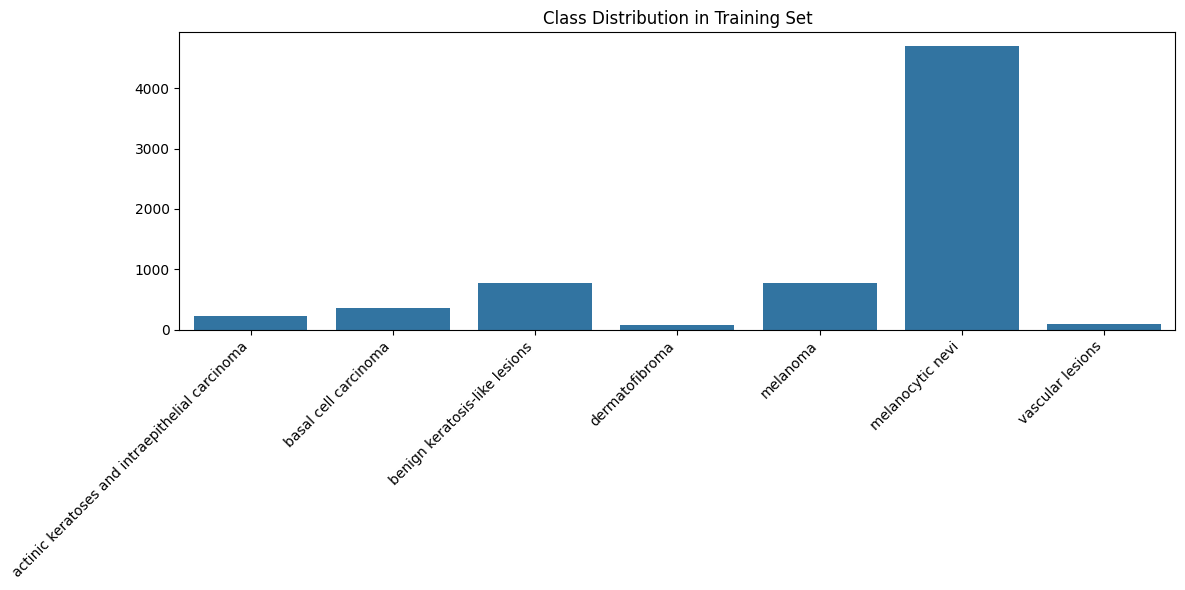

Class weights to handle imbalance: tensor([ 4.3904,  2.7883,  1.3017, 12.5125,  1.2850,  0.2133, 10.1111])


In [15]:
# CELL 4: Class Distribution Analysis
# Analyze class distribution
train_labels = [label.item() for _, label in train_loader.dataset]
class_counts = np.bincount(train_labels)

# Standardized class_names handling
if isinstance(data_info['label'], dict):
    class_names = [data_info['label'].get(str(i), f"Class {i}") for i in range(len(class_counts))]
else:
    class_names = data_info['label']

# Print class names structure to understand the issue
print("Class names structure:", type(class_names))
print("Class names content:", class_names)

# Display class distribution with standardized handling
plt.figure(figsize=(12, 6))
sns.barplot(x=range(len(class_counts)), y=class_counts)
plt.xticks(range(len(class_counts)), class_names, rotation=45, ha='right')
plt.title('Class Distribution in Training Set')
plt.tight_layout()
plt.show()

# Calculate class weights for handling imbalance
class_weights = torch.FloatTensor(len(class_counts))
for i in range(len(class_counts)):
    class_weights[i] = len(train_labels) / (class_counts[i] * len(class_counts))
print("Class weights to handle imbalance:", class_weights)

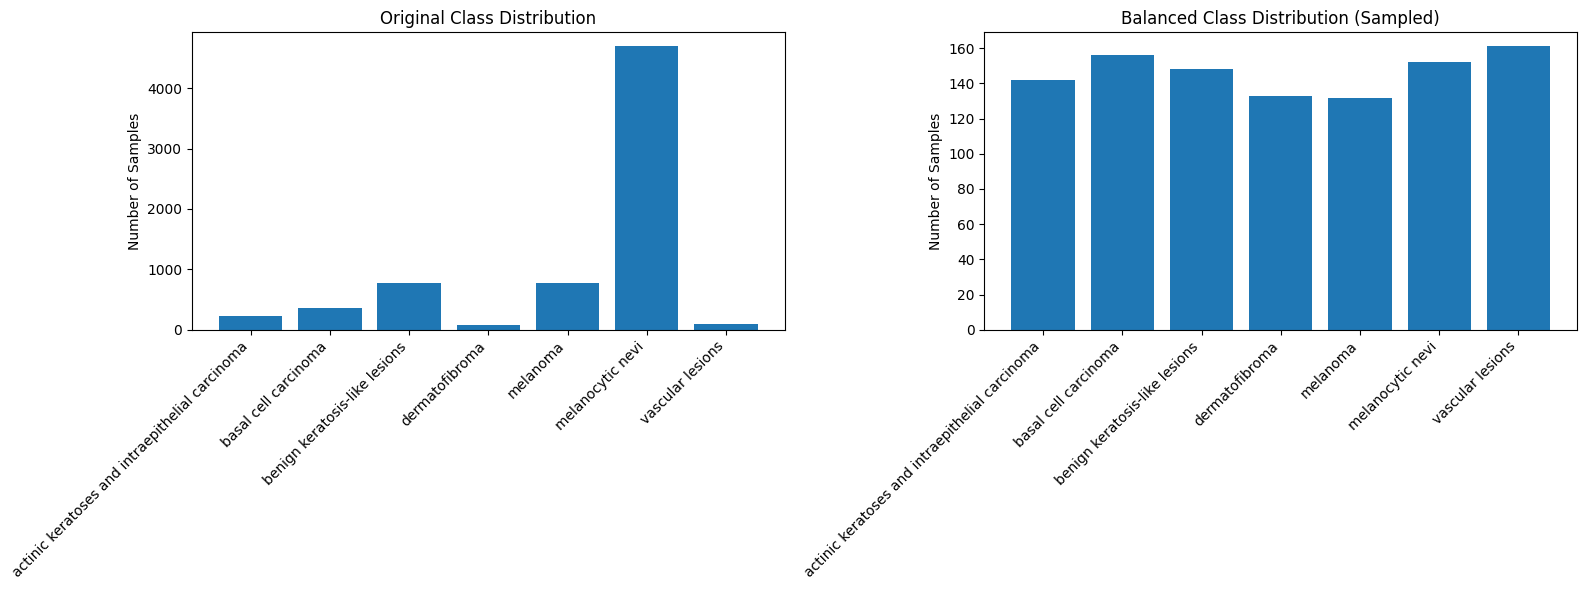

Original Distribution (%):
  actinic keratoses and intraepithelial carcinoma: 3.3%
  basal cell carcinoma: 5.1%
  benign keratosis-like lesions: 11.0%
  dermatofibroma: 1.1%
  melanoma: 11.1%
  melanocytic nevi: 67.0%
  vascular lesions: 1.4%

Balanced Distribution (%):
  actinic keratoses and intraepithelial carcinoma: 13.9%
  basal cell carcinoma: 15.2%
  benign keratosis-like lesions: 14.5%
  dermatofibroma: 13.0%
  melanoma: 12.9%
  melanocytic nevi: 14.8%
  vascular lesions: 15.7%
Data preparation complete. Ready for model training.


In [16]:
# CELL 5: Balanced Sampling with Distribution Plot
# Create weighted sampler for handling class imbalance
train_indices = list(range(len(train_dataset_transformed)))
train_targets = [train_dataset_transformed[i][1].item() for i in train_indices]
train_weights = [class_weights[label] for label in train_targets]
train_sampler = torch.utils.data.WeightedRandomSampler(
    weights=train_weights,
    num_samples=len(train_weights),
    replacement=True
)

# Create balanced loader
balanced_train_loader = DataLoader(
    train_dataset_transformed,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=2
)

# Extract labels from the balanced loader to visualize distribution
balanced_labels = []
for _, labels in balanced_train_loader:
    balanced_labels.extend(labels.cpu().numpy())
    # Stop after collecting a representative sample
    if len(balanced_labels) >= 1000:
        break

# Convert to numpy array and count classes
balanced_labels = np.array(balanced_labels)
balanced_counts = np.bincount(balanced_labels, minlength=len(class_names))

# Create a comparison plot: original vs balanced
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Original distribution
ax1.bar(range(len(class_counts)), class_counts)
ax1.set_xticks(range(len(class_counts)))
ax1.set_xticklabels(class_names, rotation=45, ha='right')
ax1.set_title('Original Class Distribution')
ax1.set_ylabel('Number of Samples')

# Balanced distribution
ax2.bar(range(len(balanced_counts)), balanced_counts)
ax2.set_xticks(range(len(balanced_counts)))
ax2.set_xticklabels(class_names, rotation=45, ha='right')
ax2.set_title('Balanced Class Distribution (Sampled)')
ax2.set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()

# Print class percentages
print("Original Distribution (%):")
original_percentages = class_counts / class_counts.sum() * 100
for i, percent in enumerate(original_percentages):
    print(f"  {class_names[i]}: {percent:.1f}%")

print("\nBalanced Distribution (%):")
balanced_percentages = balanced_counts / balanced_counts.sum() * 100
for i, percent in enumerate(balanced_percentages):
    print(f"  {class_names[i]}: {percent:.1f}%")

print("Data preparation complete. Ready for model training.")

Testing batch sizes, starting with 16...
Testing batch size: 16
  Average time per batch: 0.1435s
  Throughput: 111.5 images/second
Testing batch size: 32
  Average time per batch: 0.1441s
  Throughput: 222.1 images/second
Testing batch size: 64
  Average time per batch: 0.1625s
  Throughput: 393.9 images/second
Testing batch size: 128
  Average time per batch: 0.2470s
  Throughput: 518.2 images/second
Testing batch size: 256
  🛑 Out of GPU memory with batch size 256
Optimal batch size determined: 128
Setting batch size to 128


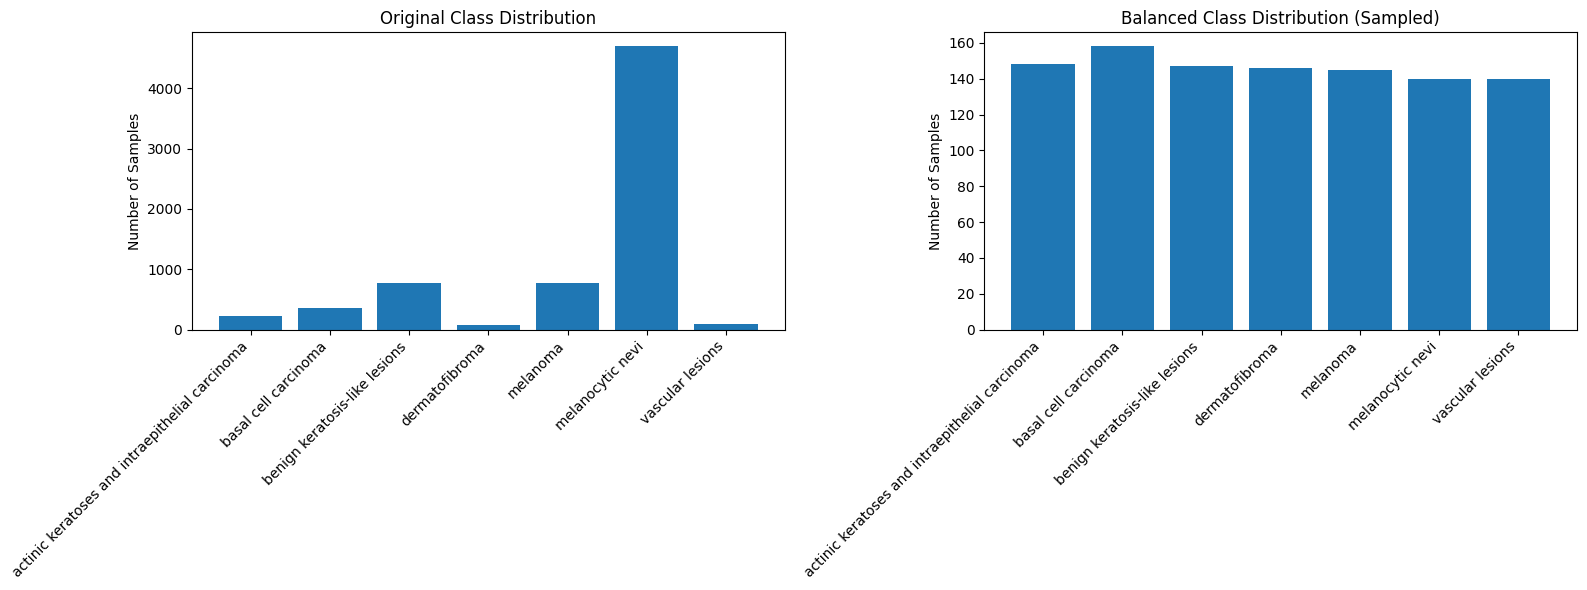

Original Distribution:
  actinic keratoses and intraepithelial carcinoma: 3.3% (228 samples)
  basal cell carcinoma: 5.1% (359 samples)
  benign keratosis-like lesions: 11.0% (769 samples)
  dermatofibroma: 1.1% (80 samples)
  melanoma: 11.1% (779 samples)
  melanocytic nevi: 67.0% (4693 samples)
  vascular lesions: 1.4% (99 samples)

Balanced Distribution:
  actinic keratoses and intraepithelial carcinoma: 14.5% (148 samples)
  basal cell carcinoma: 15.4% (158 samples)
  benign keratosis-like lesions: 14.4% (147 samples)
  dermatofibroma: 14.3% (146 samples)
  melanoma: 14.2% (145 samples)
  melanocytic nevi: 13.7% (140 samples)
  vascular lesions: 13.7% (140 samples)
Data loaders updated with batch_size=128. Ready for model training.


In [17]:
# CELL 6: Batch Size Optimization
# Create weighted sampler for handling class imbalance
train_indices = list(range(len(train_dataset_transformed)))
train_targets = [train_dataset_transformed[i][1].item() for i in train_indices]
train_weights = [class_weights[label] for label in train_targets]
train_sampler = torch.utils.data.WeightedRandomSampler(
    weights=train_weights,
    num_samples=len(train_weights),
    replacement=True
)

# Define the model for testing (using the same architecture as our main model)
def create_test_model(num_classes=7, pretrained=True):
    if pretrained:
        model = models.densenet201(weights='IMAGENET1K_V1')
    else:
        model = models.densenet201(weights=None)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model

# Try different batch sizes to find optimal value
def find_optimal_batch_size(initial_batch_size=4, max_batch_size=128, step_multiplier=2):
    if not torch.cuda.is_available():
        print("No GPU available, using default batch size of 32")
        return 32

    # Create test model, optimizer and loss function
    test_model = create_test_model(num_classes=num_classes).to(device)
    test_optimizer = optim.Adam(test_model.parameters(), lr=0.001)
    test_criterion = nn.CrossEntropyLoss()

    # Start with small batch size and increase until we get OOM error
    current_batch_size = initial_batch_size
    optimal_batch_size = current_batch_size

    print(f"Testing batch sizes, starting with {initial_batch_size}...")
    while current_batch_size <= max_batch_size:
        print(f"Testing batch size: {current_batch_size}")
        try:
            # Create test dataloader with current batch size
            test_loader = DataLoader(
                train_dataset_transformed,
                batch_size=current_batch_size,
                shuffle=True,
                num_workers=2
            )

            # Try training for a few batches
            test_model.train()
            batch_times = []

            # Test with a few batches
            num_test_batches = min(5, len(test_loader))
            for i, (images, labels) in enumerate(test_loader):
                if i >= num_test_batches:
                    break

                start_time = time.time()

                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = test_model(images)
                loss = test_criterion(outputs, labels)

                # Backward pass
                test_optimizer.zero_grad()
                loss.backward()
                test_optimizer.step()

                # Record batch processing time
                batch_times.append(time.time() - start_time)

            avg_time = sum(batch_times) / len(batch_times)
            print(f"  Average time per batch: {avg_time:.4f}s")
            print(f"  Throughput: {current_batch_size/avg_time:.1f} images/second")

            # This batch size worked, it's our new optimum
            optimal_batch_size = current_batch_size

            # Try a larger batch size
            current_batch_size *= step_multiplier

        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                print(f"  🛑 Out of GPU memory with batch size {current_batch_size}")
                break
            else:
                print(f"  Error with batch size {current_batch_size}: {e}")
                break

    # Clean up
    del test_model, test_optimizer, test_criterion
    torch.cuda.empty_cache()

    print(f"Optimal batch size determined: {optimal_batch_size}")
    return optimal_batch_size

# Find optimal batch size
optimal_batch_size = find_optimal_batch_size(initial_batch_size=16, max_batch_size=256)

# Use the optimal batch size for our data loaders
batch_size = optimal_batch_size
print(f"Setting batch size to {batch_size}")

# Recreate data loaders with optimal batch size
train_loader = DataLoader(
    train_dataset_transformed,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)
val_loader = DataLoader(
    val_dataset_transformed,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)
test_loader = DataLoader(
    test_dataset_transformed,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

# Create balanced loader with optimal batch size
balanced_train_loader = DataLoader(
    train_dataset_transformed,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=2
)

# Extract labels from the balanced loader to visualize distribution
balanced_labels = []
for _, labels in balanced_train_loader:
    balanced_labels.extend(labels.cpu().numpy())
    # Stop after collecting a representative sample
    if len(balanced_labels) >= 1000:
        break

# Convert to numpy array and count classes
balanced_labels = np.array(balanced_labels)
balanced_counts = np.bincount(balanced_labels, minlength=len(class_names))

# Create a comparison plot: original vs balanced
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Original distribution
ax1.bar(range(len(class_counts)), class_counts)
ax1.set_xticks(range(len(class_counts)))
ax1.set_xticklabels(class_names, rotation=45, ha='right')
ax1.set_title('Original Class Distribution')
ax1.set_ylabel('Number of Samples')

# Balanced distribution
ax2.bar(range(len(balanced_counts)), balanced_counts)
ax2.set_xticks(range(len(balanced_counts)))
ax2.set_xticklabels(class_names, rotation=45, ha='right')
ax2.set_title('Balanced Class Distribution (Sampled)')
ax2.set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()

# Print class percentages with sample counts
print("Original Distribution:")
original_percentages = class_counts / class_counts.sum() * 100
for i, percent in enumerate(original_percentages):
    print(f"  {class_names[i]}: {percent:.1f}% ({class_counts[i]} samples)")

print("\nBalanced Distribution:")
balanced_percentages = balanced_counts / balanced_counts.sum() * 100
for i, percent in enumerate(balanced_percentages):
    print(f"  {class_names[i]}: {percent:.1f}% ({balanced_counts[i]} samples)")

print(f"Data loaders updated with batch_size={batch_size}. Ready for model training.")

In [18]:
# CELL 7: Model Definition (DenseNet201) with Progressive Unfreezing
def create_model(num_classes=7, pretrained=True):
    """Create a DenseNet201 model with pretrained weights and initially frozen layers"""
    if pretrained:
        model = models.densenet201(weights='IMAGENET1K_V1')
    else:
        model = models.densenet201(weights=None)

    # Replace the final classifier layer
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    # Freeze all layers except the classifier
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the classifier
    for param in model.classifier.parameters():
        param.requires_grad = True

    return model

# Create the model and move to device
model_name = 'densenet201'
model = create_model(num_classes=num_classes, pretrained=True)
model = model.to(device)
print(f"Created {model_name} model with {num_classes} output classes (all layers frozen except classifier)")

Created densenet201 model with 7 output classes (all layers frozen except classifier)


In [19]:
# CELL 8: Fine-tuning Setup
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer with different learning rates for different parts
# Lower learning rate for pre-trained layers, higher for new classifier
base_params = [param for name, param in model.named_parameters() if 'classifier' not in name]
classifier_params = [param for name, param in model.named_parameters() if 'classifier' in name]

learning_rate = 1e-5  # Lower learning rate for fine-tuning
classifier_lr = 1e-4  # Higher learning rate for the classifier
weight_decay = 1e-5

optimizer = optim.AdamW([
    {'params': base_params, 'lr': learning_rate},
    {'params': classifier_params, 'lr': classifier_lr}
], weight_decay=weight_decay)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

print(f"Configured training components:")
print(f"- Loss function: {criterion.__class__.__name__}")
print(f"- Optimizer: {optimizer.__class__.__name__} (base_lr={learning_rate}, classifier_lr={classifier_lr})")
print(f"- Scheduler: {scheduler.__class__.__name__}")

Configured training components:
- Loss function: CrossEntropyLoss
- Optimizer: AdamW (base_lr=1e-05, classifier_lr=0.0001)
- Scheduler: ReduceLROnPlateau


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [20]:
# CELL 9: Training Functions with Progressive Unfreezing
# Early stopping implementation
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, verbose=True):
        """
        Early stopping to stop training when validation loss doesn't improve after a given patience.

        Args:
            patience (int): How many epochs to wait after last improvement
            min_delta (float): Minimum change to qualify as an improvement
            verbose (bool): If True, prints a message when stopping early
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss  # Higher score is better

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Training function for a single epoch
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training"):
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(loader.dataset)
    val_acc = correct / total
    return val_loss, val_acc

# Main training loop with progressive unfreezing and early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=10, device='cuda', patience=7):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0.0
    model_name = model.__class__.__name__

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    # Define unfreezing schedule - which epochs to unfreeze specific blocks
    unfreeze_schedule = {
        15: 'denseblock4',    # Unfreeze the last dense block after 15 epochs
        30: 'denseblock3',    # Unfreeze the third dense block after 30 epochs
        45: 'denseblock2',    # Unfreeze the second dense block after 45 epochs
        60: 'denseblock1'     # Unfreeze the first dense block after 60 epochs
    }

    # Track which blocks have been unfrozen
    unfrozen_blocks = set()

    print(f"Starting training for {num_epochs} epochs with progressive unfreezing and early stopping (patience={patience})...")
    for epoch in range(num_epochs):
        # Check if we need to unfreeze any blocks at this epoch
        for schedule_epoch, block_name in unfreeze_schedule.items():
            if epoch == schedule_epoch and block_name not in unfrozen_blocks:
                # Unfreeze the specified block
                for name, param in model.named_parameters():
                    if block_name in name:
                        param.requires_grad = True
                unfrozen_blocks.add(block_name)
                print(f"Epoch {epoch+1}: Unfreezing {block_name}")

                # Different learning rates for different blocks
                if block_name == 'denseblock4':
                    lr_multiplier = 0.5  # 50% of base learning rate
                elif block_name == 'denseblock3':
                    lr_multiplier = 0.3  # 30% of base learning rate
                elif block_name == 'denseblock2':
                    lr_multiplier = 0.1  # 10% of base learning rate
                elif block_name == 'denseblock1':
                    lr_multiplier = 0.05  # 5% of base learning rate

                # Group parameters by blocks to assign different learning rates
                block_params = [param for name, param in model.named_parameters()
                                if block_name in name and param.requires_grad]

                # Base learning rate from existing optimizer
                base_lr = optimizer.param_groups[0]['lr']

                # Add new parameter group for this block
                optimizer.add_param_group({
                    'params': block_params,
                    'lr': base_lr * lr_multiplier
                })

                print(f"  - Learning rate for {block_name}: {base_lr * lr_multiplier:.6f}")

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        # Update learning rate
        scheduler.step(val_loss)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"New best validation accuracy: {val_acc:.4f} - Saving model...")
            torch.save(model.state_dict(), f'best_{model_name.lower()}_dermamnist.pth')

        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    print(f"Training completed. Best validation accuracy: {best_val_acc:.4f}")
    print(f"Blocks that were unfrozen during training: {', '.join(unfrozen_blocks)}")
    return history

In [21]:
# CELL 10: Training Execution with Progressive Unfreezing
# Set number of epochs (increased to allow for all unfreezing stages)
num_epochs = 150

# Set patience for early stopping
patience = 12  # Increased slightly to allow model to adapt after unfreezing

# Initialize optimizer with just the classifier parameters initially
base_params = [param for name, param in model.named_parameters() if param.requires_grad]
optimizer = optim.AdamW(base_params, lr=1e-4, weight_decay=1e-5)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

# Train the model with progressive unfreezing
history = train_model(
    model=model,
    train_loader=balanced_train_loader,  # Using the balanced loader
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    device=device,
    patience=patience
)

Starting training for 150 epochs with progressive unfreezing and early stopping (patience=12)...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 1/150 - Train Loss: 1.9081, Train Acc: 0.2114, Val Loss: 1.8924, Val Acc: 0.2044
New best validation accuracy: 0.2044 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 2/150 - Train Loss: 1.8020, Train Acc: 0.3375, Val Loss: 1.8533, Val Acc: 0.2672
New best validation accuracy: 0.2672 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 3/150 - Train Loss: 1.7192, Train Acc: 0.4159, Val Loss: 1.7863, Val Acc: 0.3061
New best validation accuracy: 0.3061 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 4/150 - Train Loss: 1.6589, Train Acc: 0.4427, Val Loss: 1.7149, Val Acc: 0.3888
New best validation accuracy: 0.3888 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 5/150 - Train Loss: 1.6040, Train Acc: 0.4692, Val Loss: 1.6406, Val Acc: 0.4197
New best validation accuracy: 0.4197 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 6/150 - Train Loss: 1.5371, Train Acc: 0.5011, Val Loss: 1.5934, Val Acc: 0.4407
New best validation accuracy: 0.4407 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 7/150 - Train Loss: 1.5195, Train Acc: 0.4927, Val Loss: 1.5438, Val Acc: 0.4686
New best validation accuracy: 0.4686 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 8/150 - Train Loss: 1.4719, Train Acc: 0.5201, Val Loss: 1.5054, Val Acc: 0.4786
New best validation accuracy: 0.4786 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 9/150 - Train Loss: 1.4362, Train Acc: 0.5218, Val Loss: 1.4511, Val Acc: 0.4955
New best validation accuracy: 0.4955 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 10/150 - Train Loss: 1.4191, Train Acc: 0.5238, Val Loss: 1.4507, Val Acc: 0.5005
New best validation accuracy: 0.5005 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 11/150 - Train Loss: 1.3925, Train Acc: 0.5248, Val Loss: 1.3897, Val Acc: 0.4995


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 12/150 - Train Loss: 1.3662, Train Acc: 0.5409, Val Loss: 1.3892, Val Acc: 0.5125
New best validation accuracy: 0.5125 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 13/150 - Train Loss: 1.3549, Train Acc: 0.5392, Val Loss: 1.4316, Val Acc: 0.4935
EarlyStopping counter: 1 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 14/150 - Train Loss: 1.3299, Train Acc: 0.5476, Val Loss: 1.3233, Val Acc: 0.5384
New best validation accuracy: 0.5384 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 15/150 - Train Loss: 1.3174, Train Acc: 0.5485, Val Loss: 1.3116, Val Acc: 0.5334
Epoch 16: Unfreezing denseblock4
  - Learning rate for denseblock4: 0.000050


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 16/150 - Train Loss: 1.1541, Train Acc: 0.5901, Val Loss: 1.0304, Val Acc: 0.6171
New best validation accuracy: 0.6171 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 17/150 - Train Loss: 1.0064, Train Acc: 0.6392, Val Loss: 0.8599, Val Acc: 0.6640
New best validation accuracy: 0.6640 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 18/150 - Train Loss: 0.9173, Train Acc: 0.6699, Val Loss: 0.8338, Val Acc: 0.6760
New best validation accuracy: 0.6760 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 19/150 - Train Loss: 0.8720, Train Acc: 0.6820, Val Loss: 0.7277, Val Acc: 0.7298
New best validation accuracy: 0.7298 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 20/150 - Train Loss: 0.8213, Train Acc: 0.7044, Val Loss: 0.6904, Val Acc: 0.7398
New best validation accuracy: 0.7398 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 21/150 - Train Loss: 0.7521, Train Acc: 0.7226, Val Loss: 0.6692, Val Acc: 0.7458
New best validation accuracy: 0.7458 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 22/150 - Train Loss: 0.7355, Train Acc: 0.7323, Val Loss: 0.6957, Val Acc: 0.7318
EarlyStopping counter: 1 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 23/150 - Train Loss: 0.7352, Train Acc: 0.7228, Val Loss: 0.6510, Val Acc: 0.7358


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 24/150 - Train Loss: 0.6665, Train Acc: 0.7608, Val Loss: 0.6874, Val Acc: 0.7238
EarlyStopping counter: 1 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 25/150 - Train Loss: 0.6653, Train Acc: 0.7527, Val Loss: 0.6429, Val Acc: 0.7418


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 26/150 - Train Loss: 0.6480, Train Acc: 0.7640, Val Loss: 0.6376, Val Acc: 0.7507
New best validation accuracy: 0.7507 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 27/150 - Train Loss: 0.6329, Train Acc: 0.7681, Val Loss: 0.6601, Val Acc: 0.7398
EarlyStopping counter: 1 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 28/150 - Train Loss: 0.6091, Train Acc: 0.7792, Val Loss: 0.6423, Val Acc: 0.7458
EarlyStopping counter: 2 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 29/150 - Train Loss: 0.5977, Train Acc: 0.7864, Val Loss: 0.6222, Val Acc: 0.7498


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 30/150 - Train Loss: 0.5892, Train Acc: 0.7879, Val Loss: 0.6316, Val Acc: 0.7448
EarlyStopping counter: 1 out of 12
Epoch 31: Unfreezing denseblock3
  - Learning rate for denseblock3: 0.000030


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 31/150 - Train Loss: 0.5790, Train Acc: 0.7879, Val Loss: 0.5401, Val Acc: 0.7916
New best validation accuracy: 0.7916 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 32/150 - Train Loss: 0.5188, Train Acc: 0.8159, Val Loss: 0.5431, Val Acc: 0.7886
EarlyStopping counter: 1 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 33/150 - Train Loss: 0.4907, Train Acc: 0.8200, Val Loss: 0.5552, Val Acc: 0.7797
EarlyStopping counter: 2 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 34/150 - Train Loss: 0.4900, Train Acc: 0.8222, Val Loss: 0.5913, Val Acc: 0.7667
EarlyStopping counter: 3 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 35/150 - Train Loss: 0.4604, Train Acc: 0.8280, Val Loss: 0.5193, Val Acc: 0.7996
New best validation accuracy: 0.7996 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 36/150 - Train Loss: 0.4488, Train Acc: 0.8357, Val Loss: 0.4920, Val Acc: 0.8016
New best validation accuracy: 0.8016 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 37/150 - Train Loss: 0.4476, Train Acc: 0.8353, Val Loss: 0.5206, Val Acc: 0.7916
EarlyStopping counter: 1 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 38/150 - Train Loss: 0.4085, Train Acc: 0.8580, Val Loss: 0.4676, Val Acc: 0.8245
New best validation accuracy: 0.8245 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 39/150 - Train Loss: 0.3792, Train Acc: 0.8609, Val Loss: 0.4539, Val Acc: 0.8385
New best validation accuracy: 0.8385 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 40/150 - Train Loss: 0.3793, Train Acc: 0.8664, Val Loss: 0.4332, Val Acc: 0.8365


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 41/150 - Train Loss: 0.3896, Train Acc: 0.8580, Val Loss: 0.4364, Val Acc: 0.8405
New best validation accuracy: 0.8405 - Saving model...
EarlyStopping counter: 1 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 42/150 - Train Loss: 0.3622, Train Acc: 0.8697, Val Loss: 0.4237, Val Acc: 0.8385


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 43/150 - Train Loss: 0.3489, Train Acc: 0.8747, Val Loss: 0.4102, Val Acc: 0.8475
New best validation accuracy: 0.8475 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 44/150 - Train Loss: 0.3495, Train Acc: 0.8743, Val Loss: 0.4599, Val Acc: 0.8305
EarlyStopping counter: 1 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 45/150 - Train Loss: 0.3401, Train Acc: 0.8821, Val Loss: 0.4167, Val Acc: 0.8495
New best validation accuracy: 0.8495 - Saving model...
EarlyStopping counter: 2 out of 12
Epoch 46: Unfreezing denseblock2
  - Learning rate for denseblock2: 0.000010


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 46/150 - Train Loss: 0.3129, Train Acc: 0.8878, Val Loss: 0.4341, Val Acc: 0.8465
EarlyStopping counter: 3 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 47/150 - Train Loss: 0.3176, Train Acc: 0.8874, Val Loss: 0.4322, Val Acc: 0.8485
EarlyStopping counter: 4 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 48/150 - Train Loss: 0.3101, Train Acc: 0.8865, Val Loss: 0.4596, Val Acc: 0.8195
EarlyStopping counter: 5 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 49/150 - Train Loss: 0.2972, Train Acc: 0.8952, Val Loss: 0.4106, Val Acc: 0.8375
EarlyStopping counter: 6 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 50/150 - Train Loss: 0.3069, Train Acc: 0.8913, Val Loss: 0.4198, Val Acc: 0.8345
EarlyStopping counter: 7 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 51/150 - Train Loss: 0.2847, Train Acc: 0.8974, Val Loss: 0.4191, Val Acc: 0.8425
EarlyStopping counter: 8 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 52/150 - Train Loss: 0.2867, Train Acc: 0.8957, Val Loss: 0.4006, Val Acc: 0.8594
New best validation accuracy: 0.8594 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 53/150 - Train Loss: 0.2766, Train Acc: 0.9010, Val Loss: 0.4101, Val Acc: 0.8435
EarlyStopping counter: 1 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 54/150 - Train Loss: 0.2803, Train Acc: 0.9014, Val Loss: 0.4033, Val Acc: 0.8564
EarlyStopping counter: 2 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 55/150 - Train Loss: 0.2545, Train Acc: 0.9095, Val Loss: 0.4056, Val Acc: 0.8514
EarlyStopping counter: 3 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 56/150 - Train Loss: 0.2550, Train Acc: 0.9101, Val Loss: 0.4263, Val Acc: 0.8335
EarlyStopping counter: 4 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 57/150 - Train Loss: 0.2743, Train Acc: 0.9058, Val Loss: 0.4084, Val Acc: 0.8485
EarlyStopping counter: 5 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 58/150 - Train Loss: 0.2763, Train Acc: 0.9031, Val Loss: 0.3976, Val Acc: 0.8564


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 59/150 - Train Loss: 0.2723, Train Acc: 0.9057, Val Loss: 0.4040, Val Acc: 0.8465
EarlyStopping counter: 1 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 60/150 - Train Loss: 0.2572, Train Acc: 0.9104, Val Loss: 0.3974, Val Acc: 0.8574
Epoch 61: Unfreezing denseblock1
  - Learning rate for denseblock1: 0.000001


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 61/150 - Train Loss: 0.2516, Train Acc: 0.9141, Val Loss: 0.3992, Val Acc: 0.8554
EarlyStopping counter: 1 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 62/150 - Train Loss: 0.2709, Train Acc: 0.9002, Val Loss: 0.4215, Val Acc: 0.8485
EarlyStopping counter: 2 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 63/150 - Train Loss: 0.2477, Train Acc: 0.9118, Val Loss: 0.3948, Val Acc: 0.8624
New best validation accuracy: 0.8624 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 64/150 - Train Loss: 0.2549, Train Acc: 0.9091, Val Loss: 0.4001, Val Acc: 0.8544
EarlyStopping counter: 1 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 65/150 - Train Loss: 0.2554, Train Acc: 0.9095, Val Loss: 0.4078, Val Acc: 0.8475
EarlyStopping counter: 2 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 66/150 - Train Loss: 0.2559, Train Acc: 0.9098, Val Loss: 0.4046, Val Acc: 0.8524
EarlyStopping counter: 3 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 67/150 - Train Loss: 0.2483, Train Acc: 0.9147, Val Loss: 0.4082, Val Acc: 0.8554
EarlyStopping counter: 4 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 68/150 - Train Loss: 0.2458, Train Acc: 0.9109, Val Loss: 0.4136, Val Acc: 0.8534
EarlyStopping counter: 5 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 69/150 - Train Loss: 0.2381, Train Acc: 0.9182, Val Loss: 0.4104, Val Acc: 0.8524
EarlyStopping counter: 6 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 70/150 - Train Loss: 0.2520, Train Acc: 0.9085, Val Loss: 0.3927, Val Acc: 0.8644
New best validation accuracy: 0.8644 - Saving model...


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 71/150 - Train Loss: 0.2595, Train Acc: 0.9101, Val Loss: 0.4069, Val Acc: 0.8574
EarlyStopping counter: 1 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 72/150 - Train Loss: 0.2419, Train Acc: 0.9129, Val Loss: 0.3996, Val Acc: 0.8614
EarlyStopping counter: 2 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 73/150 - Train Loss: 0.2570, Train Acc: 0.9121, Val Loss: 0.3993, Val Acc: 0.8564
EarlyStopping counter: 3 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 74/150 - Train Loss: 0.2504, Train Acc: 0.9097, Val Loss: 0.4059, Val Acc: 0.8554
EarlyStopping counter: 4 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 75/150 - Train Loss: 0.2507, Train Acc: 0.9128, Val Loss: 0.4001, Val Acc: 0.8574
EarlyStopping counter: 5 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 76/150 - Train Loss: 0.2401, Train Acc: 0.9165, Val Loss: 0.3947, Val Acc: 0.8644
EarlyStopping counter: 6 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 77/150 - Train Loss: 0.2457, Train Acc: 0.9099, Val Loss: 0.4045, Val Acc: 0.8594
EarlyStopping counter: 7 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 78/150 - Train Loss: 0.2529, Train Acc: 0.9118, Val Loss: 0.4061, Val Acc: 0.8594
EarlyStopping counter: 8 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 79/150 - Train Loss: 0.2329, Train Acc: 0.9195, Val Loss: 0.3950, Val Acc: 0.8634
EarlyStopping counter: 9 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 80/150 - Train Loss: 0.2435, Train Acc: 0.9124, Val Loss: 0.4055, Val Acc: 0.8594
EarlyStopping counter: 10 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 81/150 - Train Loss: 0.2331, Train Acc: 0.9175, Val Loss: 0.3948, Val Acc: 0.8634
EarlyStopping counter: 11 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 82/150 - Train Loss: 0.2439, Train Acc: 0.9135, Val Loss: 0.3883, Val Acc: 0.8644


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 83/150 - Train Loss: 0.2501, Train Acc: 0.9114, Val Loss: 0.3924, Val Acc: 0.8634
EarlyStopping counter: 1 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 84/150 - Train Loss: 0.2575, Train Acc: 0.9109, Val Loss: 0.3907, Val Acc: 0.8664
New best validation accuracy: 0.8664 - Saving model...
EarlyStopping counter: 2 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 85/150 - Train Loss: 0.2529, Train Acc: 0.9099, Val Loss: 0.3930, Val Acc: 0.8634
EarlyStopping counter: 3 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 86/150 - Train Loss: 0.2477, Train Acc: 0.9098, Val Loss: 0.3935, Val Acc: 0.8634
EarlyStopping counter: 4 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 87/150 - Train Loss: 0.2365, Train Acc: 0.9172, Val Loss: 0.3972, Val Acc: 0.8634
EarlyStopping counter: 5 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 88/150 - Train Loss: 0.2498, Train Acc: 0.9127, Val Loss: 0.3992, Val Acc: 0.8634
EarlyStopping counter: 6 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 89/150 - Train Loss: 0.2447, Train Acc: 0.9135, Val Loss: 0.3892, Val Acc: 0.8644
EarlyStopping counter: 7 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 90/150 - Train Loss: 0.2402, Train Acc: 0.9177, Val Loss: 0.3871, Val Acc: 0.8654


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 91/150 - Train Loss: 0.2277, Train Acc: 0.9192, Val Loss: 0.3971, Val Acc: 0.8614
EarlyStopping counter: 1 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 92/150 - Train Loss: 0.2439, Train Acc: 0.9137, Val Loss: 0.3939, Val Acc: 0.8644
EarlyStopping counter: 2 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 93/150 - Train Loss: 0.2409, Train Acc: 0.9187, Val Loss: 0.4013, Val Acc: 0.8614
EarlyStopping counter: 3 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 94/150 - Train Loss: 0.2472, Train Acc: 0.9134, Val Loss: 0.3927, Val Acc: 0.8644
EarlyStopping counter: 4 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 95/150 - Train Loss: 0.2426, Train Acc: 0.9151, Val Loss: 0.3912, Val Acc: 0.8624
EarlyStopping counter: 5 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 96/150 - Train Loss: 0.2325, Train Acc: 0.9188, Val Loss: 0.3994, Val Acc: 0.8584
EarlyStopping counter: 6 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 97/150 - Train Loss: 0.2426, Train Acc: 0.9181, Val Loss: 0.3997, Val Acc: 0.8614
EarlyStopping counter: 7 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 98/150 - Train Loss: 0.2388, Train Acc: 0.9161, Val Loss: 0.3981, Val Acc: 0.8624
EarlyStopping counter: 8 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 99/150 - Train Loss: 0.2541, Train Acc: 0.9102, Val Loss: 0.3951, Val Acc: 0.8644
EarlyStopping counter: 9 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 100/150 - Train Loss: 0.2478, Train Acc: 0.9161, Val Loss: 0.4016, Val Acc: 0.8604
EarlyStopping counter: 10 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 101/150 - Train Loss: 0.2486, Train Acc: 0.9107, Val Loss: 0.3942, Val Acc: 0.8644
EarlyStopping counter: 11 out of 12


Training:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 102/150 - Train Loss: 0.2445, Train Acc: 0.9164, Val Loss: 0.3919, Val Acc: 0.8654
EarlyStopping counter: 12 out of 12
Early stopping triggered after 102 epochs
Training completed. Best validation accuracy: 0.8664
Blocks that were unfrozen during training: denseblock4, denseblock2, denseblock1, denseblock3


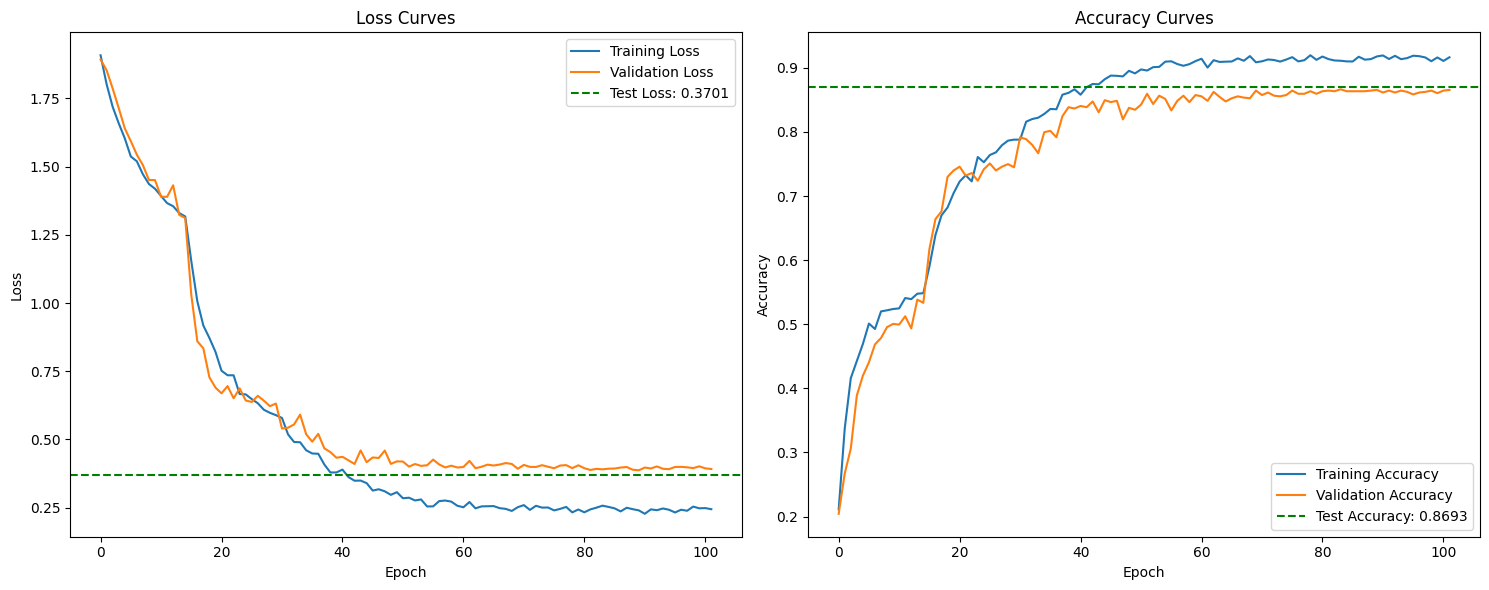

Final Training Loss: 0.2445, Accuracy: 0.9164
Final Validation Loss: 0.3919, Accuracy: 0.8654
Final Test Loss: 0.3701, Accuracy: 0.8693
Generalization gap (train-val): 0.0510
Generalization gap (train-test): 0.0470


In [22]:
# CELL 11: Extended Training Visualization with Test Metrics

# Get final test metrics
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Calculate loss and accuracy
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate final metrics
final_test_loss = test_loss / len(test_loader.dataset)
final_test_acc = correct / total

# Plot comprehensive training metrics
plt.figure(figsize=(15, 6))

# Loss plot with test
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.axhline(y=final_test_loss, color='g', linestyle='--', label=f'Test Loss: {final_test_loss:.4f}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Accuracy plot with test
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.axhline(y=final_test_acc, color='g', linestyle='--', label=f'Test Accuracy: {final_test_acc:.4f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.show()

# Print comparison of final metrics
print(f"Final Training Loss: {history['train_loss'][-1]:.4f}, Accuracy: {history['train_acc'][-1]:.4f}")
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}, Accuracy: {history['val_acc'][-1]:.4f}")
print(f"Final Test Loss: {final_test_loss:.4f}, Accuracy: {final_test_acc:.4f}")

# Calculate generalization gap
train_val_gap = history['train_acc'][-1] - history['val_acc'][-1]
train_test_gap = history['train_acc'][-1] - final_test_acc
print(f"Generalization gap (train-val): {train_val_gap:.4f}")
print(f"Generalization gap (train-test): {train_test_gap:.4f}")

Performing comprehensive model evaluation...


Evaluating on training set:   0%|          | 0/55 [00:00<?, ?it/s]

Evaluating on validation set:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating on test set:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating on training set:
Accuracy: 0.8630
F1-Macro Score: 0.8215
ROC-AUC Macro: 0.9894
PR-AUC Macro: 0.9446
Per-class metrics:
Class 0 (actinic keratoses and intraepithelial carcinoma): Accuracy: 0.9605 F1: 0.8571 ROC-AUC: 0.9977 PR-AUC: 0.9575
Class 1 (basal cell carcinoma): Accuracy: 0.9248 F1: 0.8469 ROC-AUC: 0.9968 PR-AUC: 0.9546
Class 2 (benign keratosis-like lesions): Accuracy: 0.8882 F1: 0.8136 ROC-AUC: 0.9847 PR-AUC: 0.9216
Class 3 (dermatofibroma): Accuracy: 0.9625 F1: 0.7857 ROC-AUC: 0.9990 PR-AUC: 0.9570
Class 4 (melanoma): Accuracy: 0.8742 F1: 0.7184 ROC-AUC: 0.9690 PR-AUC: 0.8394
Class 5 (melanocytic nevi): Accuracy: 0.8432 F1: 0.9087 ROC-AUC: 0.9790 PR-AUC: 0.9898
Class 6 (vascular lesions): Accuracy: 0.9899 F1: 0.8201 ROC-AUC: 0.9999 PR-AUC: 0.9920
Evaluating on validation set:
Accuracy: 0.8654
F1-Macro Score: 0.7934
ROC-AUC Macro: 0.9801
PR-AUC Macro: 0.8688
Per-class metrics:
Class 0 (actinic keratoses and intraepithelial carcinoma): Accuracy: 0.7576 F1: 0.6944 ROC-

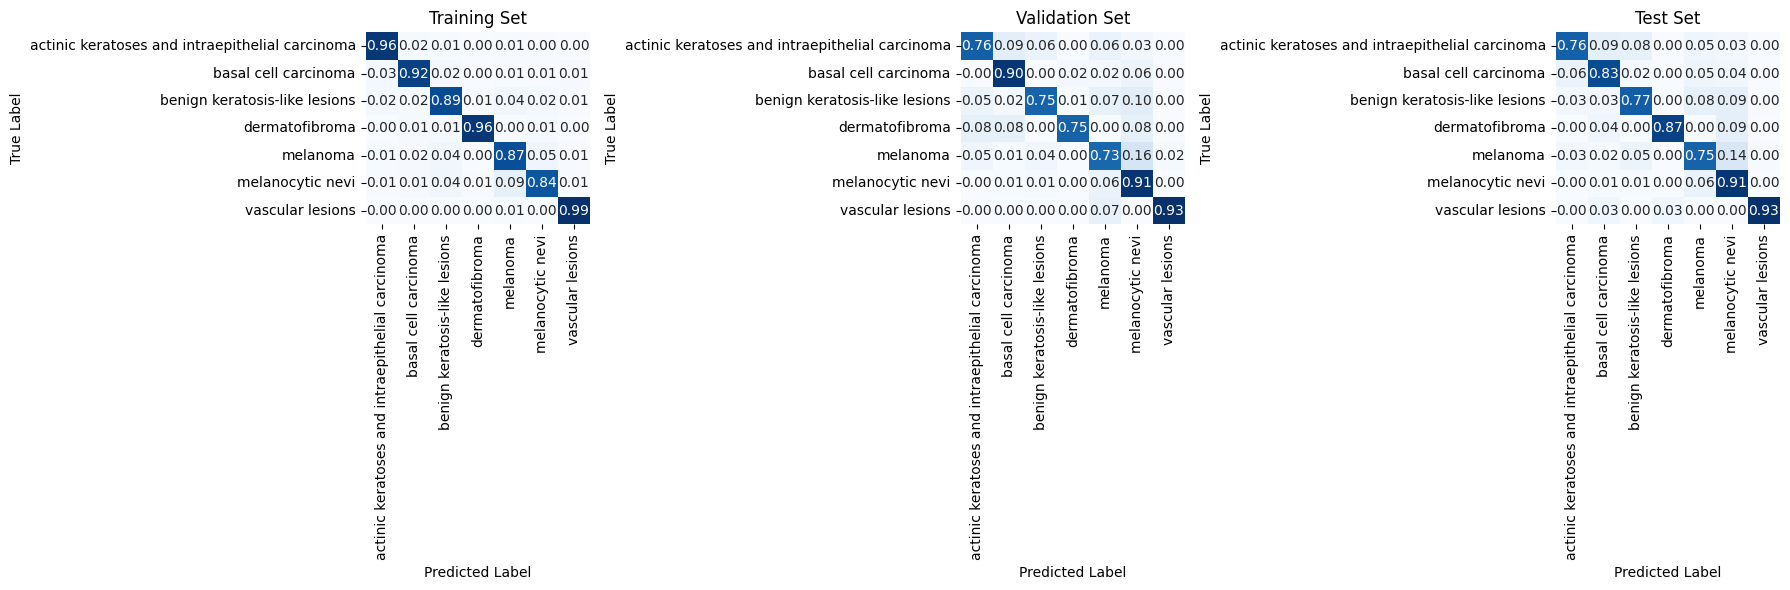

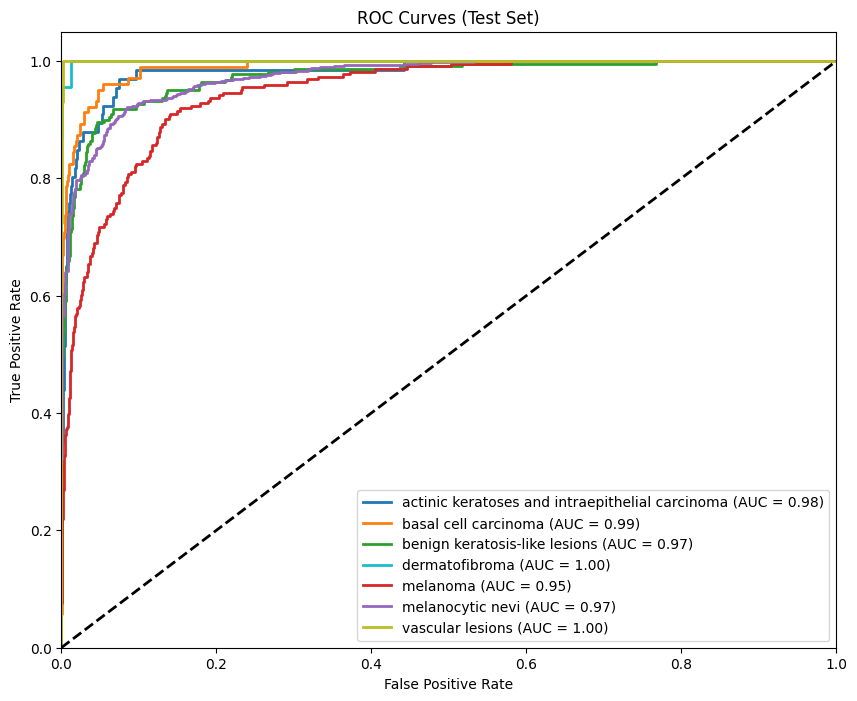

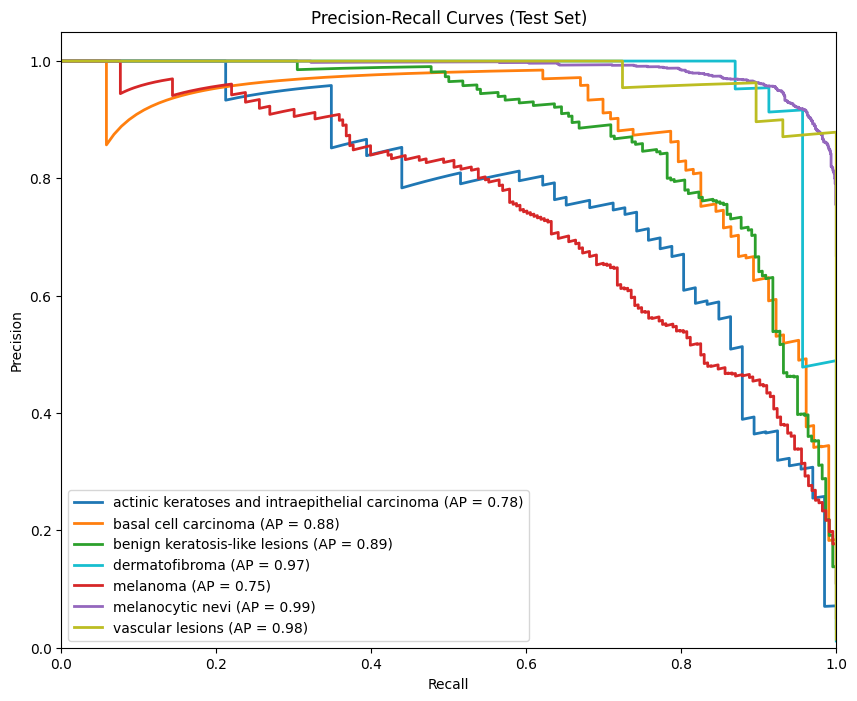

In [23]:
# CELL 12: Comprehensive Model Evaluation Metrics

# Define consistent color mapping for exact same colors
class_colors = {
    'actinic keratoses and intraepithelial carcinoma': '#1f77b4',  # blue
    'basal cell carcinoma': '#ff7f0e',                  # orange
    'benign keratosis-like lesions': '#2ca02c',         # green
    'dermatofibroma': '#17becf',                        # cyan
    'melanoma': '#d62728',                              # red
    'melanocytic nevi': '#9467bd',                      # purple
    'vascular lesions': '#bcbd22'                       # yellow
}

def evaluate_model(model, loader, device, split_name=""):
    """Comprehensive model evaluation on a given dataset"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f"Evaluating on {split_name}"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    predictions = np.array(all_preds)
    true_labels = np.array(all_labels)
    probabilities = np.array(all_probs)

    # Overall metrics
    accuracy = accuracy_score(true_labels, predictions)
    f1_macro = f1_score(true_labels, predictions, average='macro')

    # One-hot encode for ROC and PR metrics
    n_classes = len(class_names)
    y_true_bin = np.eye(n_classes)[true_labels]

    # Per-class metrics
    f1_per_class = f1_score(true_labels, predictions, average=None)

    # Calculate per-class accuracy
    acc_per_class = []
    for i in range(n_classes):
        class_mask = (true_labels == i)
        if np.sum(class_mask) > 0:  # Avoid division by zero
            class_correct = np.sum((predictions == i) & class_mask)
            class_total = np.sum(class_mask)
            acc_per_class.append(class_correct / class_total)
        else:
            acc_per_class.append(float('nan'))

    # ROC-AUC per class and macro
    roc_auc_per_class = []
    pr_auc_per_class = []

    for i in range(n_classes):
        # ROC-AUC
        if len(np.unique(y_true_bin[:, i])) > 1:  # Check if both classes are present
            roc_auc = roc_auc_score(y_true_bin[:, i], probabilities[:, i])
        else:
            roc_auc = float('nan')  # Handle single-class case
        roc_auc_per_class.append(roc_auc)

        # PR-AUC
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], probabilities[:, i])
        pr_auc = auc(recall, precision)
        pr_auc_per_class.append(pr_auc)

    # Calculate macro averages
    roc_auc_macro = np.nanmean(roc_auc_per_class)
    pr_auc_macro = np.nanmean(pr_auc_per_class)

    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Return all metrics
    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'roc_auc_macro': roc_auc_macro,
        'pr_auc_macro': pr_auc_macro,
        'f1_per_class': f1_per_class,
        'acc_per_class': acc_per_class,
        'roc_auc_per_class': roc_auc_per_class,
        'pr_auc_per_class': pr_auc_per_class,
        'confusion_matrix': cm,
        'predictions': predictions,
        'true_labels': true_labels,
        'probabilities': probabilities
    }

# Evaluate on all three sets
print("Performing comprehensive model evaluation...")
train_metrics = evaluate_model(model, train_loader, device, "training set")
val_metrics = evaluate_model(model, val_loader, device, "validation set")
test_metrics = evaluate_model(model, test_loader, device, "test set")

# Print metrics in the requested format
def print_metrics(metrics, split_name):
    print(f"Evaluating on {split_name}:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1-Macro Score: {metrics['f1_macro']:.4f}")
    print(f"ROC-AUC Macro: {metrics['roc_auc_macro']:.4f}")
    print(f"PR-AUC Macro: {metrics['pr_auc_macro']:.4f}")

    print("Per-class metrics:")
    for i in range(len(class_names)):
        print(f"Class {i} ({class_names[i]}): Accuracy: {metrics['acc_per_class'][i]:.4f} "
              f"F1: {metrics['f1_per_class'][i]:.4f} "
              f"ROC-AUC: {metrics['roc_auc_per_class'][i]:.4f} "
              f"PR-AUC: {metrics['pr_auc_per_class'][i]:.4f}")

# Print metrics for all datasets
print_metrics(train_metrics, "training set")
print_metrics(val_metrics, "validation set")
print_metrics(test_metrics, "test set")

# Performance comparison table
print("=== Performance Comparison ===")
print("Metric           Training   Validation   Test")
print("---------------------------------------------")
print(f"Accuracy         {train_metrics['accuracy']:.4f}     {val_metrics['accuracy']:.4f}     {test_metrics['accuracy']:.4f}")
print(f"F1-Macro         {train_metrics['f1_macro']:.4f}     {val_metrics['f1_macro']:.4f}     {test_metrics['f1_macro']:.4f}")
print(f"ROC-AUC Macro    {train_metrics['roc_auc_macro']:.4f}     {val_metrics['roc_auc_macro']:.4f}     {test_metrics['roc_auc_macro']:.4f}")
print(f"PR-AUC Macro     {train_metrics['pr_auc_macro']:.4f}     {val_metrics['pr_auc_macro']:.4f}     {test_metrics['pr_auc_macro']:.4f}")

# Calculate overfitting ratios
acc_ratio_train_val = train_metrics['accuracy'] / val_metrics['accuracy']
acc_ratio_train_test = train_metrics['accuracy'] / test_metrics['accuracy']
print(f"Overfitting ratio (train/val): {acc_ratio_train_val:.4f}")
print(f"Overfitting ratio (train/test): {acc_ratio_train_test:.4f}")

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Function to plot confusion matrix
def plot_cm(cm, ax, title):
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    ax.set_title(title)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

# Plot all three confusion matrices
plot_cm(train_metrics['confusion_matrix'], axes[0], 'Training Set')
plot_cm(val_metrics['confusion_matrix'], axes[1], 'Validation Set')
plot_cm(test_metrics['confusion_matrix'], axes[2], 'Test Set')

plt.tight_layout()
plt.show()

# Plot ROC curves for test set
plt.figure(figsize=(10, 8))

for i, class_label in enumerate(class_names):
    # Calculate ROC curve
    y_true = np.eye(len(class_names))[test_metrics['true_labels']][:, i]
    y_score = test_metrics['probabilities'][:, i]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = test_metrics['roc_auc_per_class'][i]

    plt.plot(fpr, tpr, color=class_colors[class_label], lw=2,
             label=f'{class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Test Set)')
plt.legend(loc="lower right")
plt.show()

# Plot PR curves for test set
plt.figure(figsize=(10, 8))

for i, class_label in enumerate(class_names):
    # Calculate PR curve
    y_true = np.eye(len(class_names))[test_metrics['true_labels']][:, i]
    y_score = test_metrics['probabilities'][:, i]
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    pr_auc = test_metrics['pr_auc_per_class'][i]

    plt.plot(recall, precision, color=class_colors[class_label], lw=2,
             label=f'{class_label} (AP = {pr_auc:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (Test Set)')
plt.legend(loc="lower left")
plt.show()

Extracting features embeddings for visualization...


Extracting features:   0%|          | 0/16 [00:00<?, ?it/s]

Extracted 2005 feature vectors of dimension 1920
Performing t-SNE dimensionality reduction (2D)...


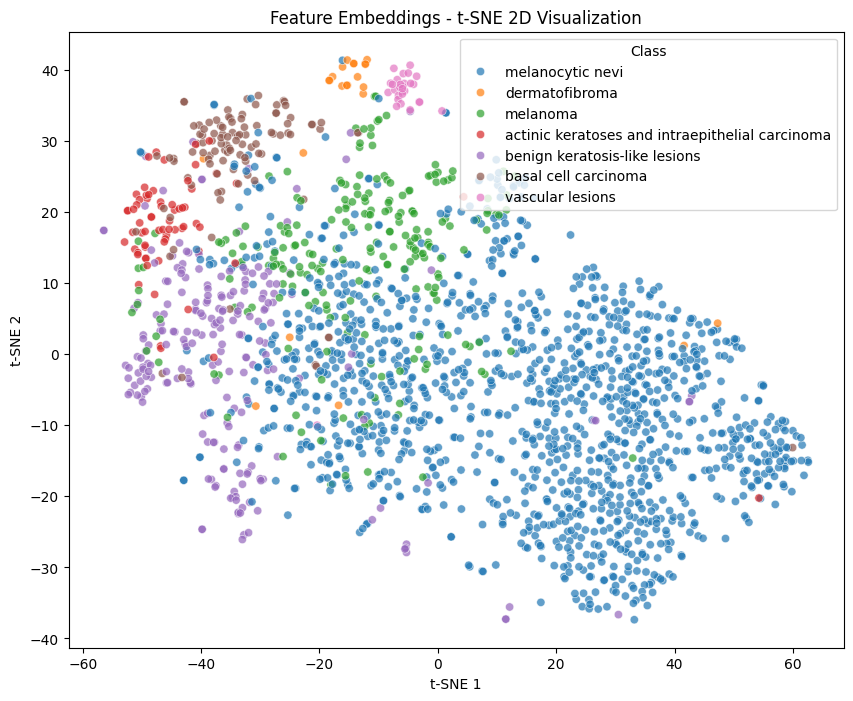

Performing t-SNE dimensionality reduction (3D)...


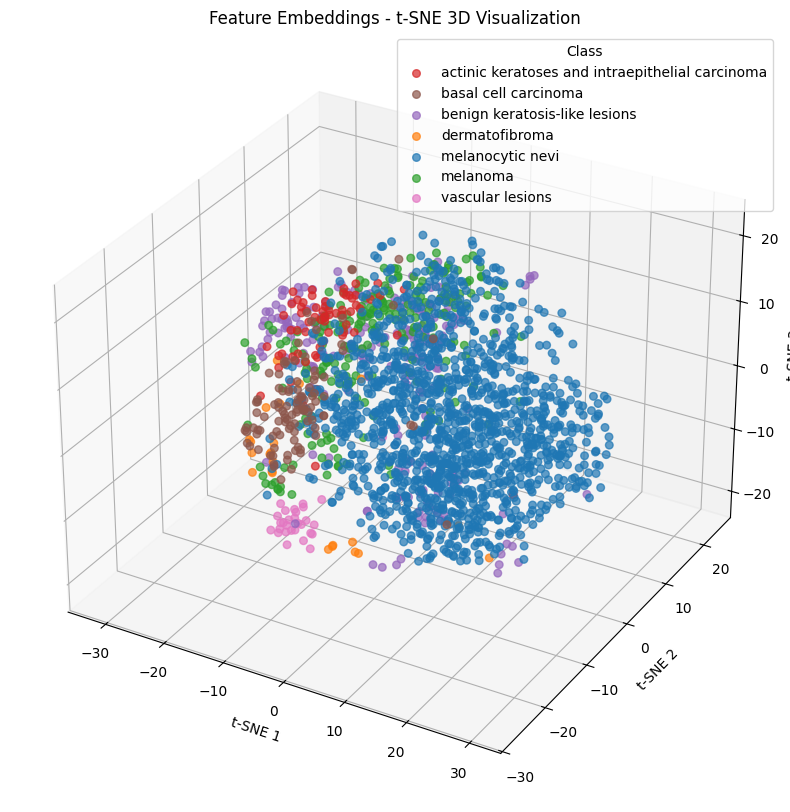

Performing UMAP dimensionality reduction (2D)...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


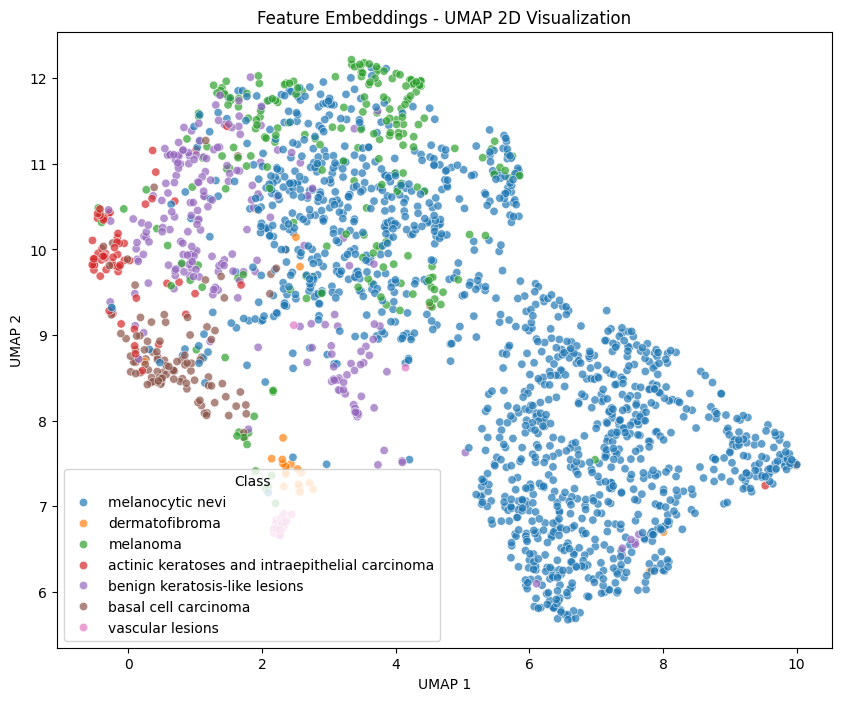

Performing UMAP dimensionality reduction (3D)...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


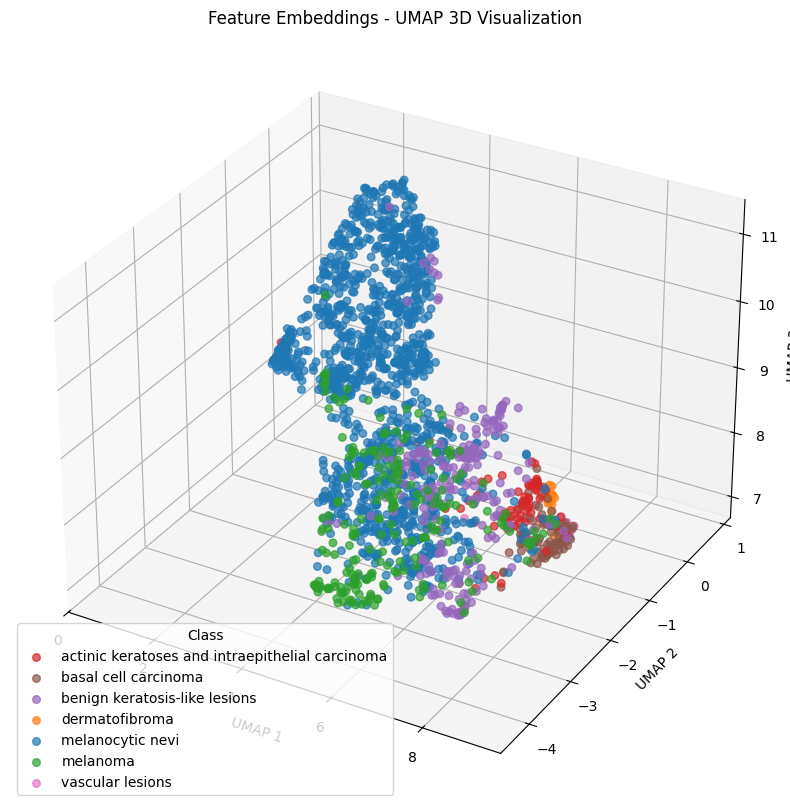

Feature embeddings visualization comparison:
- t-SNE: Better for preserving local structure and revealing clusters
  - Advantages: Preserves neighborhoods, good for finding clusters
  - Limitations: Loses global structure, different runs may vary
- UMAP: Balance between local and global structure
  - Advantages: Faster than t-SNE, preserves both local and some global structure
  - Limitations: Parameter sensitive, may emphasize separation over true distances


In [24]:
# CELL 13: Feature Embeddings Visualization with t-SNE and UMAP

# Create a directory for saving plots
os.makedirs("plots", exist_ok=True)

# Define consistent color mapping for exact same colors
class_colors = {
    'melanocytic nevi': '#1f77b4',           # blue
    'dermatofibroma': '#ff7f0e',             # orange
    'melanoma': '#2ca02c',                   # green
    'actinic keratoses and intraepithelial carcinoma': '#d62728',  # red
    'benign keratosis-like lesions': '#9467bd',  # purple
    'basal cell carcinoma': '#8c564b',       # brown
    'vascular lesions': '#e377c2'            # pink
}

# Modified function for feature extraction with DenseNet201
def extract_features(model, data_loader, device):
    # Create a copy of the model to avoid modifying the original
    feature_extractor = copy.deepcopy(model)

    # For DenseNet201, we need to get features before the classifier
    if hasattr(feature_extractor, 'classifier'):
        # DenseNet has features and classifier
        if hasattr(feature_extractor, 'features'):
            # Keep just the features part for DenseNet
            original_features = feature_extractor.features

            # Add global pooling to match DenseNet's standard feature extraction
            feature_extractor = nn.Sequential(
                original_features,
                nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool2d((1, 1)),
                nn.Flatten()
            )
        else:
            # For other models like ConvNeXt, replace classifier with identity
            feature_extractor.classifier = nn.Identity()
    else:
        # Fallback for other architectures - remove last layer
        modules = list(feature_extractor.children())[:-1]
        feature_extractor = nn.Sequential(*modules)

    feature_extractor.eval()

    features = []
    labels = []

    with torch.no_grad():
        for images, batch_labels in tqdm(data_loader, desc="Extracting features"):
            images = images.to(device)
            batch_features = feature_extractor(images)

            # Flatten if needed
            if len(batch_features.shape) > 2:
                batch_features = batch_features.reshape(batch_features.shape[0], -1)

            features.append(batch_features.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return np.vstack(features), np.array(labels)

# Standardize class_names handling
if isinstance(data_info['label'], dict):
    class_names = [data_info['label'].get(str(i), f"Class {i}") for i in range(num_classes)]
else:
    class_names = data_info['label']

# Extract features from the test set
print("Extracting features embeddings for visualization...")
features, labels = extract_features(model, test_loader, device)
print(f"Extracted {features.shape[0]} feature vectors of dimension {features.shape[1]}")

# Get unique class labels for consistent ordering
unique_labels = sorted([class_names[l] for l in np.unique(labels)])

# 1. t-SNE Visualization - 2D
print("Performing t-SNE dimensionality reduction (2D)...")
plt.figure(figsize=(10, 8))
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30)
features_tsne_2d = tsne_2d.fit_transform(features)

# Create DataFrame for easier plotting
df_tsne_2d = pd.DataFrame({
    'x': features_tsne_2d[:, 0],
    'y': features_tsne_2d[:, 1],
    'label': [class_names[l] for l in labels]
})

# Plot t-SNE 2D with consistent colors
sns.scatterplot(data=df_tsne_2d, x='x', y='y', hue='label', palette=class_colors, alpha=0.7)
plt.title('Feature Embeddings - t-SNE 2D Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Class')
plt.savefig('plots/tsne_2d_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. t-SNE Visualization - 3D
print("Performing t-SNE dimensionality reduction (3D)...")
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
features_tsne_3d = tsne_3d.fit_transform(features)

# Create DataFrame for 3D plotting
df_tsne_3d = pd.DataFrame({
    'x': features_tsne_3d[:, 0],
    'y': features_tsne_3d[:, 1],
    'z': features_tsne_3d[:, 2],
    'label': [class_names[l] for l in labels]
})

# Plot t-SNE 3D with consistent colors
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each class with consistent colors
for label in unique_labels:
    mask = df_tsne_3d['label'] == label
    ax.scatter(
        df_tsne_3d.loc[mask, 'x'],
        df_tsne_3d.loc[mask, 'y'],
        df_tsne_3d.loc[mask, 'z'],
        color=class_colors[label],
        label=label,
        alpha=0.7,
        s=30
    )

ax.set_title('Feature Embeddings - t-SNE 3D Visualization')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
ax.legend(title='Class')
plt.savefig('plots/tsne_3d_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. UMAP Visualization - 2D
print("Performing UMAP dimensionality reduction (2D)...")
plt.figure(figsize=(10, 8))
umap_2d = umap.UMAP(n_components=2, random_state=42)
features_umap_2d = umap_2d.fit_transform(features)

# Create DataFrame for easier plotting
df_umap_2d = pd.DataFrame({
    'x': features_umap_2d[:, 0],
    'y': features_umap_2d[:, 1],
    'label': [class_names[l] for l in labels]
})

# Plot UMAP 2D with consistent colors
sns.scatterplot(data=df_umap_2d, x='x', y='y', hue='label', palette=class_colors, alpha=0.7)
plt.title('Feature Embeddings - UMAP 2D Visualization')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Class')
plt.savefig('plots/umap_2d_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. UMAP Visualization - 3D
print("Performing UMAP dimensionality reduction (3D)...")
umap_3d = umap.UMAP(n_components=3, random_state=42)
features_umap_3d = umap_3d.fit_transform(features)

# Create DataFrame for 3D plotting
df_umap_3d = pd.DataFrame({
    'x': features_umap_3d[:, 0],
    'y': features_umap_3d[:, 1],
    'z': features_umap_3d[:, 2],
    'label': [class_names[l] for l in labels]
})

# Plot UMAP 3D with consistent colors
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each class with consistent colors
for label in unique_labels:
    mask = df_umap_3d['label'] == label
    ax.scatter(
        df_umap_3d.loc[mask, 'x'],
        df_umap_3d.loc[mask, 'y'],
        df_umap_3d.loc[mask, 'z'],
        color=class_colors[label],
        label=label,
        alpha=0.7,
        s=30
    )

ax.set_title('Feature Embeddings - UMAP 3D Visualization')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.legend(title='Class')
plt.savefig('plots/umap_3d_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare the methods
print("Feature embeddings visualization comparison:")
print("- t-SNE: Better for preserving local structure and revealing clusters")
print("  - Advantages: Preserves neighborhoods, good for finding clusters")
print("  - Limitations: Loses global structure, different runs may vary")
print("- UMAP: Balance between local and global structure")
print("  - Advantages: Faster than t-SNE, preserves both local and some global structure")
print("  - Limitations: Parameter sensitive, may emphasize separation over true distances")